# ＰＢＲ１倍割れ解消 日足

In [1]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [2]:
pattern = re.compile(r'(.+)\.T')

symbol = '2080.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2024-09-26 00:00:00+09:00,1110.0,1124.0,1107.0,1121.0,127882,0.0,0.0,0.0
2024-09-27 00:00:00+09:00,1125.0,1136.0,1122.0,1134.0,177940,0.0,0.0,0.0
2024-09-30 00:00:00+09:00,1092.0,1122.0,1092.0,1112.0,214824,0.0,0.0,0.0
2024-10-01 00:00:00+09:00,1123.0,1132.0,1120.0,1129.0,104310,0.0,0.0,0.0
2024-10-02 00:00:00+09:00,1122.0,1130.0,1114.0,1116.0,40411,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-03-19 00:00:00+09:00,1264.0,1274.0,1264.0,1273.0,36107,0.0,0.0,0.0
2025-03-21 00:00:00+09:00,1270.0,1285.0,1268.0,1282.0,58680,0.0,0.0,0.0
2025-03-24 00:00:00+09:00,1278.0,1281.0,1271.0,1274.0,16858,0.0,0.0,0.0


## 日足チャートとパラボリック SAR

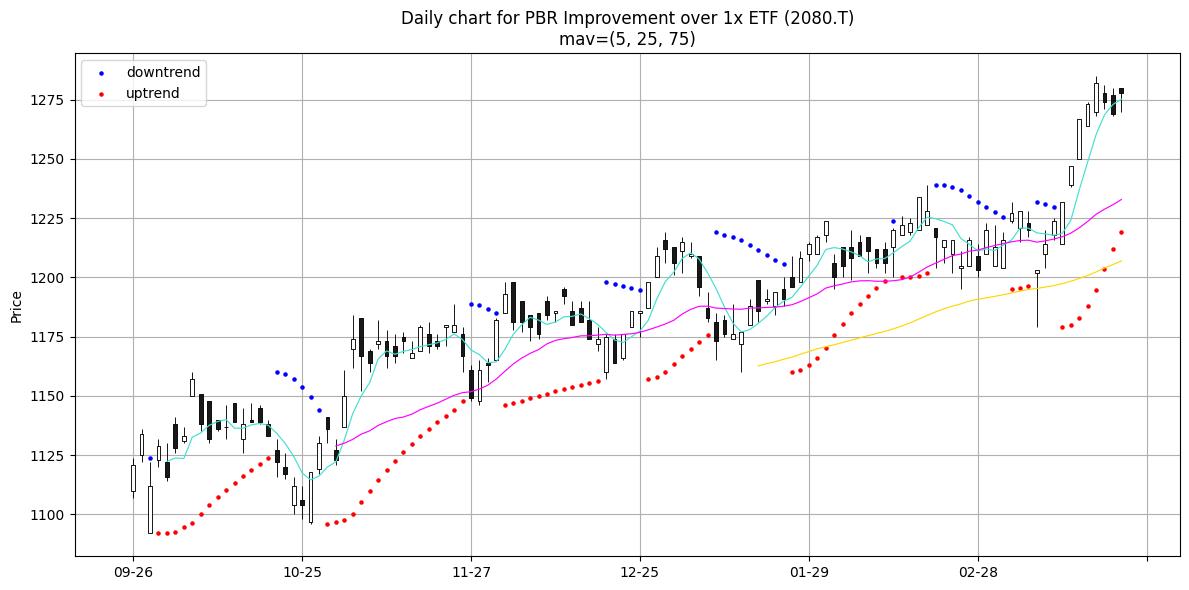

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-25 00:00:00+09:00    1269.0
2025-03-26 00:00:00+09:00    1278.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-25 00:00:00+09:00    NaN
2025-03-26 00:00:00+09:00    9.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-03-25 00:00:00+09:00    1273.0
2025-03-26 00:00:00+09:00    1275.2
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-03-25 00:00:00+09:00    1230.68
2025-03-26 00:00:00+09:00    1232.88
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-03-25 00:00:00+09:00    1205.426667
2025-03-26 00:00:00+09:00    1206.960000
Name: Close, dtype: float64